In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatLogSlider, fixed
from scipy.stats import norm
import random

def n_pdf(x, mu=0., sigma=1.): # normal pdf
    u = (x - mu) / abs(sigma)
    y = (1 / (np.sqrt(2 * np.pi) * abs(sigma)))
    y *= np.exp(-u * u / 2)   
    return y
        
def ksdensity(data, width=0.3):
    """Returns kernel smoothing function from data points in data"""
    def ksd(x_axis):  
        prob = [n_pdf(x_i, data, width) for x_i in x_axis]
        pdf = [np.average(pr) for pr in prob] # each row is one x value
        return np.array(pdf)
    return ksd

def calc_norm_bin_probabilities(bins):
    '''Returns an array containing the probabilities of a gaussian number lying in each bin'''
    return[norm.cdf(bins[i+1]) - norm.cdf(bins[i]) for i in range(len(bins)-1)]

def calc_norm_scaler(func_width, no_bins, n, func_max):
    '''Returns the scaling factor to scale a standard normal to a histogram 
    by calculating the probability of a random gaussian number lying in 
    a bin centred on zero and therefore the proportion of histogram data
    that you'd expect to lie in this bin'''
    delta = func_width/no_bins
    area = norm.cdf(0+delta/2) - norm.cdf(0-delta/2)
    return area*n/func_max

def calc_scaler(bins, bin_heights, x, y, N, asymptotes=False):
    '''Returns a scaling factor to scale a pdf to a histogram representing
    a probability distribution. Using the Jacobian transformation 
    to generate the pdf of a function of a random variable can lead to 
    asymptotes in the pdf when there are turning points in the function. 
    The  effects of this can be minimised by setting the asymptotes argument 
    to true'''
    
    #Calculate the area covered by the histogram and estimate area under pdf using trapezium rule
    pdf_area = sum(abs(x[i+1] - x[i]) * (y[i+1] + y[i])/2 for i in range(len(x) - 1))
    hist_area = sum((bins[i+1] - bins[i]) * bin_heights[i] for i in range(len(bin_heights)))
    scaler = hist_area/pdf_area
    
    if not asymptotes:
        return scaler
    
    else:
        #A cutoff is used to minimise the affects of super large values near the asymptotes of the pdf
        #During numerical integration, any values greater than the cutoff will be replaced with the cutoff value
        cutoff = 2 * max(bin_heights)/scaler 
        pdf_area_a = sum(abs((x[i+1] - x[i]) * ((min(y[i+1], cutoff) + min(y[i], cutoff))/2)) 
                       for i in range(len(x) - 1))
    
    scaler = hist_area/pdf_area_a
    return scaler

def theoretical_mean_and_std(N, bin_probs, no_bins):
    '''Returns the theoretical mean and standard deviation of the histogram count data'''
    mean = sum(N*prob for prob in bin_probs)/no_bins
    var = sum(N*prob*(1-prob) for prob in bin_probs)/no_bins
    return [mean, np.sqrt(var)]

## Uniform and Normal Random Variables

In [2]:
def plot_smoothed_normal_with_histo(N, width=0.3, show_ideal=True):
    # Generate and plot histogram of N gaussian random numbers
    fig, ax = plt.subplots(1, figsize = (8, 5))
    x = np.random.randn(int(N))
    ax.hist(x, bins=30, color='orange', label ='Histogram Data') 

    #Generate smoothed density function and x values for plotting
    ks_density = ksdensity(x, width)
    x_values = np.linspace(-5., 5., 100)
    
    #Calculate Scaling factor for each function
    func_range = max(list(ax.hist(x, bins=30))[1]) - min(list(ax.hist(x, bins=30))[1]) #find range of hist data
    max_ks = max(ks_density(x_values))
    ks_scaler = calc_norm_scaler(func_range, 30, N, max_ks)
    
    max_norm = max(n_pdf(x_values))
    scaler_n = calc_norm_scaler(func_range, 30, N, max_norm)
    
    #Plot
    if show_ideal:
        ax.plot(x_values, scaler_n * n_pdf(x_values), color='lime', label='Exact Gaussian Curve')
    
    ax.plot(x_values, ks_scaler * ks_density(x_values), color='black', label='Kernel Density Estimate')
    ax.set_title('Histogram of Randomly Generated Gaussian Numbers with Kernel Density Estimate and Ideal Curve')
        
    ax.legend()


def plot_smoothed_uniform_with_histo(N, width=0.3, show_ideal=True):
    # Generate and plot histogram of 1000 uniform random numbers
    fig2, ax2 = plt.subplots(1, figsize = (8, 5))
    x = np.random.rand(int(N))
    ax2.hist(x, bins=30, color='orange', label='Histogram Data')
    
    #Generate smoothed density function and x values for plotting
    ks_density = ksdensity(x, width)
    x_values = np.linspace(-1., 2., 3000)
    y_ideal = np.concatenate((np.zeros(1000), np.ones(1000), np.zeros(1000)))
    
    #Calculate Scaling factor
    mid_ks = [y for y in ks_density(x_values) if 0.5<y<1.5]
    scaler_ks = np.mean(list(ax2.hist(x, bins=30))[0]) / np.mean(mid_ks)
    scaler_ideal = np.mean(list(ax2.hist(x, bins=30))[0])
    
    #Plot
    if show_ideal:
        ax2.plot(x_values, scaler_ideal * y_ideal, color='lime', label='Ideal Uniform Distribution')
        
    ax2.plot(x_values, scaler_ks * ks_density(x_values), color='black', label='Kernel Density Estimate')
    ax2.set_title('Histogram of Uniform Random Numbers with Kernel Density Estimate and Ideal Curve')
    ax2.legend()

interact(plot_smoothed_normal_with_histo, width=(0, 2, 0.1), N=FloatLogSlider(min=1, max=4, step=1))
interact(plot_smoothed_uniform_with_histo, width=(0.01, 0.55, 0.04), N=FloatLogSlider(min=1, max=4, step=1))

interactive(children=(FloatLogSlider(value=10.0, description='N', min=1.0, step=1.0), FloatSlider(value=0.3, d…

interactive(children=(FloatLogSlider(value=10.0, description='N', min=1.0, step=1.0), FloatSlider(value=0.3, d…

<function __main__.plot_smoothed_uniform_with_histo(N, width=0.3, show_ideal=True)>

In [11]:
def plot_normal_with_histo(no_bins, sd_lines = True, mean = True):
    fig_n, ax_n = plt.subplots(1, 3, figsize = (12, 4))
    
    for i in range(3):
        N = 10**(i+2)
    
        x_vals_n = np.linspace(-5., 5., 1000)
        rand_n = np.random.randn(int(N)) #uniformly generate N random  gaussian numbers


        #Create lists of bins, their data counts and their associated probabilities
        bin_heights_n = ax_n[i].hist(rand_n, bins=no_bins)[0]
        bins_n = ax_n[i].hist(rand_n, bins=no_bins)[1]
        bin_probs_n = calc_norm_bin_probabilities(bins_n)

        #Calculate theoretical mean and standard deviation of the histogram count data
        theo_mean, theo_std = theoretical_mean_and_std(N, bin_probs_n, no_bins)

        #Plotting
        if mean == True:
            ax_n[i].hlines(theo_mean, bins_n[0], bins_n[-1], color='magenta', 
                        label='Theoretical mean of Hist Data')

        if sd_lines == True:
            ax_n[i].hlines([theo_mean+3*theo_std, theo_mean-3*theo_std], bins_n[0], bins_n[-1], 
                    color='black', label='+/- 3 SD lines')

        ax_n[i].hist(rand_n, bins=no_bins, color='orange', label='Histogram Data')
        ax_n[i].set_title(f'N = {N}')
        
        if i == 2:
            ax_n[i].legend(loc='upper right')

    
def plot_uniform_with_histo(no_bins, sd_lines=True, mean=True):
    fig_u, ax_u = plt.subplots(1, 3, figsize = (12, 4))
    
    for i in range(3):
        N = 10**(i+2)
        x_vals_u = np.linspace(-0., 1., N)
        rand_u = np.random.rand(int(N)) #uniformly generate N gaussian random numbers

        scaler_u = np.mean(list(ax_u[i].hist(rand_u, bins=no_bins))[0]) #height of ideal uniform distribution is mean bar height

        #Create lists of bins, their data counts and their associated probabilities
        bin_heights_u = ax_u[i].hist(rand_u, bins=no_bins)[0]
        bins_u = ax_u[i].hist(rand_u, bins=no_bins)[1]
        bin_probs_u = np.ones(no_bins) / no_bins

        theo_mean, theo_std = theoretical_mean_and_std(N, bin_probs_u, no_bins)

        #Plotting
        if mean == True:
            ax_u[i].hlines(theo_mean, bins_u[0], bins_u[-1], color='magenta', 
                        label='Theoretical mean of Hist Data')

        if sd_lines == True:
            ax_u[i].hlines([theo_mean+3*theo_std, theo_mean-3*theo_std], bins_u[0], bins_u[-1], 
                    color='black', label='+/- 3 SD lines')

        ax_u[i].hist(rand_u, bins=no_bins, color='orange', label='Histogram Data')
        ax_u[i].set_title(f'N = {N}')

        if i == 2:
            ax_u[i].legend(loc='lower right')
    
    
interact(plot_normal_with_histo, N=FloatLogSlider(min=1, max=4, step=1), no_bins=(1, 100, 20))
interact(plot_uniform_with_histo, no_bins=(5, 100, 5))

interactive(children=(IntSlider(value=41, description='no_bins', min=1, step=20), Checkbox(value=True, descrip…

interactive(children=(IntSlider(value=50, description='no_bins', min=5, step=5), Checkbox(value=True, descript…

<function __main__.plot_uniform_with_histo(no_bins, sd_lines=True, mean=True)>

## Functions of Random Variables

In [4]:
def y1(x, a=3, b=5, diff=False, inverse=False):
    '''Returns function, its derivative or inverse'''
    if diff == True:
        return abs(a)
    elif inverse == True:
        return [(x - b)/a]
    else:
        return a*x + b

    
def y2(x, diff=False, inverse=False):
    '''Returns function, derivative or inverse'''
    if diff == True:
        return abs(2*x)
    elif inverse == True:
        return [np.sqrt(x), -np.sqrt(x)]
    else:
        return x**2
    
def y_EP(x, a=2, diff=False, inverse=False):
    '''Returns function, derivative or inverse'''
    if diff == True:
        if abs(x) < a:
            return 0
        else:
            return 1
        
    elif inverse == True:
        if x > a:
            return x+a
        elif x < -a:
            return x-a
        else:
            return random.uniform(-a, a)
    else:
        if x > a:
            return x-a
        elif x < -a:
            return x+a
        else:
            return 0


def plot_func(N, title, f, no_bins, pdf, axes_lim=False, trig=False, asym=False, overlay=True,
              dist_type='gaussian'):
    if trig:
        rand_x = np.random.uniform(0, 2*np.pi, int(N))
    else:
        rand_x = np.random.randn(int(N))
    
    #Generate ordered (needed for numerical integration) list of evenly spaced y values for a given x range
    x_vals_hist = np.linspace(-5., 5., 1000)
    y_vals_hist_unsorted = f(x_vals_hist) #for non 1-1 functions this list will not be ordered
    start =  min(y_vals_hist_unsorted)
    stop = max(y_vals_hist_unsorted)
    y_vals_hist = np.linspace(start, stop, 1000)
    
    
    fig, ax = plt.subplots(2, figsize = (10, 10))
    
    if overlay:
        #Generate p(y) using the Jacobian Transformation
        prob_y = np.array([(sum(pdf(x_k)/abs(f(x_k, diff=True)) for x_k in f(y, inverse=True))) 
                            for y in y_vals_hist])
    
        #Create lists of bin edges and bin heights
        bins = list(ax[1].hist(f(rand_x), bins=no_bins)[1])
        bin_heights = list(ax[1].hist(f(rand_x), bins=no_bins)[0])    

        #Calculate scaling factor to scale pdf to histogram
        scaler = calc_scaler(bins, bin_heights, y_vals_hist, prob_y, N, asymptotes=asym)   
    
    #Plot f(x) as a function of random variable X to visualise distribution
    ax[0].plot(rand_x, f(rand_x), 'x')
    ax[0].set_title(f'f(x) = {title} for random {dist_type} variable X')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('f(x)')
    ax[0].grid()
    
    #Limits the size of the axes to the histogram data rather the pdf plot
    if axes_lim:
        ax[1].set_ylim(bottom=0, top=1.2*max(list(ax[1].hist(f(rand_x), bins=no_bins)[0])))
        ax[1].set_xlim(left= 1.1*min(list(ax[1].hist(f(rand_x), bins=no_bins)[1])), 
                       right=1.1*max(list(ax[1].hist(f(rand_x), bins=no_bins)[1])))
    
    #Plot histogram and overlay pdf
    ax[1].hist(f(rand_x), bins=no_bins, color='violet', label='Histogram Data')
    
    if overlay:
        ax[1].plot(y_vals_hist, prob_y*scaler, color='black', label='p(y)')
    
    ax[1].set_title(f'Probability distribution of {title} for random {dist_type} variable X')
    ax[1].set_xlabel(f'{title}')
    ax[1].legend()
    
       
interact(plot_func, N=FloatLogSlider(min=1, max=4, step=1), title=fixed('3x + 5'), f=fixed(y1), 
        no_bins=(5, 50, 5), pdf=fixed(n_pdf), axes_lim=fixed(False), trig=fixed(False),
        asym=fixed(False), dist_type=fixed('gaussian'), overlay=fixed(True))

interact(plot_func, N=FloatLogSlider(min=1, max=4, step=1), title=fixed('x^2'), f=fixed(y2), 
        no_bins=(5, 50, 5), pdf=fixed(n_pdf), axes_lim=fixed(True), trig=fixed(False),
        asym=fixed(True), dist_type=fixed('gaussian'), overlay=fixed(True))

interactive(children=(FloatLogSlider(value=10.0, description='N', min=1.0, step=1.0), IntSlider(value=25, desc…

interactive(children=(FloatLogSlider(value=10.0, description='N', min=1.0, step=1.0), IntSlider(value=25, desc…

<function __main__.plot_func(N, title, f, no_bins, pdf, axes_lim=False, trig=False, asym=False, overlay=True, dist_type='gaussian')>

In [5]:
def y4(x, diff=False, inverse=False):
    '''Returns function, derivative or inverse'''
    if diff == True:
        return np.cos(x)
    elif inverse == True:
        if np.arcsin(x) > 0:
            return[np.arcsin(x), np.pi - np.arcsin(x)]
        else:
            return[2*np.pi + np.arcsin(x), np.pi - np.arcsin(x)]
    else:
        return np.sin(x)
    
def uniform_trig_pdf(x):
    if 0 <= x <= 2*np.pi:
        return 1/(2*np.pi)
    else:
        return 0


interact(plot_func, N=FloatLogSlider(min=1, max=4, step=1), title=fixed('sin(x)'), f=fixed(y4), 
         no_bins=(5, 50, 5), pdf=fixed(uniform_trig_pdf), axes_lim=fixed(True), trig=fixed(True),
        asym=fixed(True), dist_type=fixed('uniform'), overlay=fixed(True))

interactive(children=(FloatLogSlider(value=10.0, description='N', min=1.0, step=1.0), IntSlider(value=25, desc…

<function __main__.plot_func(N, title, f, no_bins, pdf, axes_lim=False, trig=False, asym=False, overlay=True, dist_type='gaussian')>

"interact(plot_func, N=FloatLogSlider(min=1, max=4, step=1), title=fixed('sin(x)'), f=fixed(y5), \n         no_bins=(5, 50, 5), pdf=fixed(uniform_trig_pdf), axes_lim=fixed(True), trig=fixed(True),\n        asym=fixed(True), dist_type=fixed('uniform'), overlay=fixed(False))"

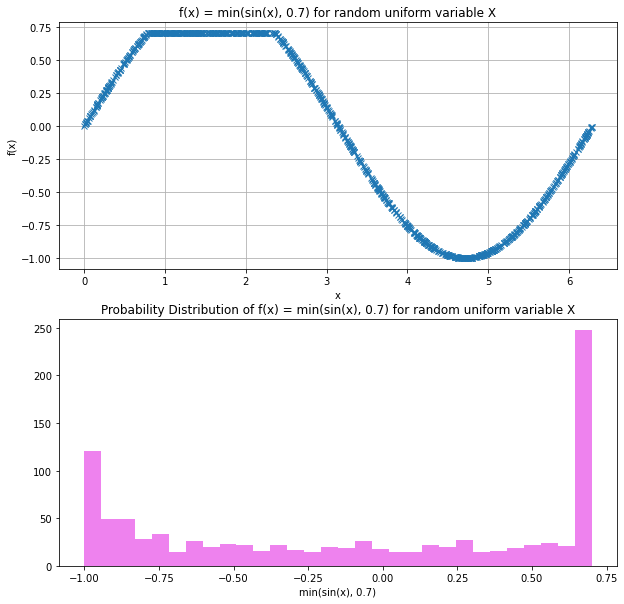

In [6]:
def y5(x, diff=False, inverse=False):
    '''Returns function, derivative or inverse'''
    if diff == True:
        if sin(x) < 0.7:
            return np.cos(x)
        else:
            return 0
    elif inverse == True:
        if np.arcsin(x) > 0:
            return[np.arcsin(x), np.pi - np.arcsin(x)]
        
    else:
        return [min(np.sin(x_i), 0.7) for x_i in x]


#Generate randomly distributed x values
rand_x = np.random.uniform(0, 2*np.pi, 1000)    

#Generate ordered (needed for numerical integration) list of evenly spaced y values for a given x range
x_vals_hist = np.linspace(-5., 5., 1000)
y_vals_hist_unsorted = y5(x_vals_hist) #for non 1-1 functions this list will not be ordered
start =  min(y_vals_hist_unsorted)
stop = max(y_vals_hist_unsorted)
y_vals_hist = np.linspace(start, stop, 1000)

fig, ax = plt.subplots(2, figsize = (10, 10))

#Plot f(x) as a function of random variable X to visualise distribution
ax[0].plot(rand_x, y5(rand_x), 'x')
ax[0].set_title(f'f(x) = min(sin(x), 0.7) for random uniform variable X')
ax[0].set_xlabel('x')
ax[0].set_ylabel('f(x)')
ax[0].grid()

#Plot histogram 
ax[1].hist(y5(rand_x), bins=30, color='violet', label='Histogram Data')
ax[1].set_xlabel('min(sin(x), 0.7)')
ax[1].set_title('Probability Distribution of f(x) = min(sin(x), 0.7) for random uniform variable X')


    
'''interact(plot_func, N=FloatLogSlider(min=1, max=4, step=1), title=fixed('sin(x)'), f=fixed(y5), 
         no_bins=(5, 50, 5), pdf=fixed(uniform_trig_pdf), axes_lim=fixed(True), trig=fixed(True),
        asym=fixed(True), dist_type=fixed('uniform'), overlay=fixed(False))'''

## Inverse CDF Method

In [7]:
def distribution1(y, pdf=True, cdf=False, inv_cdf=False):
    if cdf:
        return 1 - np.exp(-y)
    elif inv_cdf:
        return -np.log(1-y)
    else:
        return np.exp(-y)

def plot_using_inverse_CDF(N, no_bins, dist, kernel_width, title, show_kd_estimate=True,
                          monte_carlo=False):
    rand_x = np.random.rand(int(N))
    y_vals = np.linspace(0., 10., 1000)
    fig, ax = plt.subplots(1, figsize = (8, 8))
    
    Y = dist(rand_x, inv_cdf=True)
    prob_y = dist(y_vals)
    ks_density = ksdensity(Y, width=kernel_width)
    smoothed = ks_density(y_vals)
    
    
    
    bins = list(ax.hist(Y, bins=no_bins)[1])
    bin_heights = list(ax.hist(Y, bins=no_bins)[0])
    
    scaler_ks = calc_scaler(bins, bin_heights, y_vals, smoothed, N)
    scaler_pdf = calc_scaler(bins, bin_heights, y_vals, prob_y, N)
    
    ax.hist(Y, bins=no_bins, color='violet', label='Histogram Data')
    if show_kd_estimate:
        ax.plot(y_vals, smoothed*scaler_ks, color='black', label='Kernel Density Estimate')
    ax.plot(y_vals, prob_y*scaler_pdf, color='green', label=f'p(y) = {title}')
    ax.set_xlabel('y')
    ax.legend()
    
    if monte_carlo:
        mu = sum(Y)/ N
        print(f'Monte Carlo Mean Estimate: {mu}')
        var = sum(Y**2)/N - mu**2
        print(f'Monte Carlo Variance Estimate {var}')

    
interact(plot_using_inverse_CDF, N=FloatLogSlider(min=1, max=4, step=1), dist=fixed(distribution1), 
         no_bins=(5, 50, 5), kernel_width=(0.05, 1, 0.05), title=fixed('e^-y'))

interactive(children=(FloatLogSlider(value=10.0, description='N', min=1.0, step=1.0), IntSlider(value=25, desc…

<function __main__.plot_using_inverse_CDF(N, no_bins, dist, kernel_width, title, show_kd_estimate=True, monte_carlo=False)>

In [8]:
def monte_carlo_error_plot(N_max, iterations, mu, dist):
    squared_error = []
    N_arr = []
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    for N in range(1, int(N_max)):
        rand_x = np.random.rand(int(N))
        Y = dist(rand_x, inv_cdf=True)
        mu_est = sum(Y)/ N
        squared_error.append((mu_est-mu)**2)
        N_arr.append(N)
            
    ax[0].plot(N_arr, squared_error, color='orange')
    ax[0].set_xlabel('N')
    ax[0].set_title('One set of samples')
    ax[0].set_ylabel('Squared error')
    
    squared_error = []
    N_arr = []
    
    for N in range(1, int(N_max)):
        errors = []
        for i in range(int(iterations)):
            rand_x = np.random.rand(int(N))
            Y = dist(rand_x, inv_cdf=True)
            mu_est = sum(Y)/ N
            errors.append(abs(mu_est-mu))
            
        squared_error.append(np.mean(errors)**2)
        N_arr.append(N)   
        
    
    ax[1].plot(N_arr, squared_error, color='green')
    ax[1].set_xlabel('N')
    ax[1].set_title('Ten sets of samples')
    ax[1].set_ylabel('Mean Squared error')
        
    
interact(monte_carlo_error_plot, N_max=FloatLogSlider(min=1, max=4, step=1), 
         iterations=FloatLogSlider(min=0, max=4, step=1), mu=fixed(1), dist=fixed(distribution1))

interactive(children=(FloatLogSlider(value=10.0, description='N_max', min=1.0, step=1.0), FloatLogSlider(value…

<function __main__.monte_carlo_error_plot(N_max, iterations, mu, dist)>

## Simulation from Non-Standard Densities

In [9]:
#Define pdf and inverse cdf for random variable U
def U_dist(u, a, inv_cdf=False):
    if inv_cdf:
        return -2 * np.log(1-u) / a**2
    else:
        return a**2/2 * np.exp(-a**2 * u/2)

def plotX(a, N, no_bins, width):
    x = np.linspace(-5.,  5., 1000)
    fig, ax = plt.subplots(3, figsize = (12, 12))
    
    rand_unif = np.random.rand(int(N)) #generate N random numbers from a uniform distribution
    
    #generate N random numbers from distribution of random variable U using inverse CDF method
    U = U_dist(rand_unif, a, inv_cdf=True)
    
    #generate N random numbers from distribution of random variable X (Gaussian with random variance u)
    X = [np.random.normal(loc=0, scale=np.sqrt(U_i)) for U_i in U]
    
    ks_density = ksdensity(X, width=width)
    
    ax[0].hist(U, bins=no_bins, color='violet')
    ax[0].set_title('Distribution of random variable U')
    ax[1].hist(X, bins=no_bins, color='violet')
    ax[1].set_title('Distribution of random variable X randomly generated from normal with variance U w')
    
    ax[2].plot(x, np.log(ks_density(x)), color = 'orange', label = f'alpha = {a}')
    ax[2].set_title('Natural Log of Kernel Density Estimate')
    ax[2].grid(\'[]\'[]                                                            

SyntaxError: unexpected character after line continuation character (<ipython-input-9-272cfbc9f872>, line 29)

In [ ]:
import scipy.stats as stats

def plotX2(N, width, no_bins=30):
    x = np.linspace(-100.,  100., 1000)
    fig, ax = plt.subplots(3, 3, figsize = (15, 15))
    fig1, ax1 = plt.subplots(3, figsize = (6, 16))
    
    for i in range(3):
        theta = 2 ** (i+1)**2
        
        #generate N random numbers from Gaussian distribution 
        V = np.random.gamma(theta, 1/theta, int(N))
        U = 1/V

        #Get bin positions and heights for scaling
        bins_v = list(ax[i][0].hist(V, bins=no_bins)[1])
        bin_heights_v = list(ax[i][0].hist(V, bins=no_bins)[0])
        bins_u = list(ax[i][1].hist(U, bins=no_bins)[1])
        bin_heights_u = list(ax[i][1].hist(U, bins=no_bins)[0])

        #Create array of u values to plot p(u)
        start_u =  min(bins_u) - abs(min(bins_u)) * 0.5
        stop_u = max(bins_u) + abs(max(bins_u)) * 0.5
        u_vals = np.linspace(start_u, stop_u, 1000)
        prob_u = stats.gamma.pdf(1/u_vals, a=theta, scale=1/theta) / u_vals**2

        start_v =  min(bins_v)
        stop_v = max(bins_v)
        v_vals = np.linspace(start_v, stop_v, 1000)
        prob_v = stats.gamma.pdf(v_vals, a=theta, scale=1/theta)

        scaler_u = calc_scaler(bins_u, bin_heights_u, u_vals, prob_u, N)
        scaler_v = calc_scaler(bins_v, bin_heights_v, v_vals, prob_v, N)

        #generate N random numbers from distribution of random variable X (Gaussian with random variance 1/v)
        X = [np.random.normal(loc=0, scale=np.sqrt(1/u)) for u in U]
        ks_density = ksdensity(X, width=width)

        ax[i][0].hist(V, bins=no_bins, color='magenta')
        ax[i][0].plot(v_vals, prob_v*scaler_v, color='green')
        ax[i][0].set_title(f'Distribution of random variable V,  theta= {theta}')

        ax[i][1].hist(U, bins=no_bins, color='magenta')
        ax[i][1].plot(u_vals, prob_u*scaler_u, color='green', label = 'ideal curve')
        ax[i][1].set_title(f'Distribution of random variable U, theta = {theta}')
        
        if i == 0:
            ax[i][1].legend()
        
        ax[i][2].hist(X, bins=no_bins, color='magenta')
        ax[i][2].set_title(f'Distribution of random variable X, theta = {theta}')
        
        ax1[i].plot(x, np.log(ks_density(x)), color = 'orange')
        ax1[i].set_title(f'Natural Log of Kernel Density Estimate, theta = {theta}')
        ax1[i].grid()
        ax1[i].set_xlim([-100, 100])
        
        
    
interact(plotX2, theta = FloatLogSlider(min=-1, max=4, step=1), N=FloatLogSlider(min=1, max=4, step=1), 
         no_bins=(5, 50, 5), width=(0.1, 1, 0.1))